In [ ]:
###Import Packages###
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from skimage import io, color

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

##Upload Data and unzip them

In [ ]:
# UN-comment this section if need to remove any folder/directory
# !rm -rf /content/data

In [ ]:
!mkdir data/

In [ ]:
###Unzip DATA###

#Before run the code section, manually upload data to the file space / work space
!unzip /content/original_img.zip -d /content/data/
!unzip /content/masked_img.zip -d /content/data/
os.rename('/content/data/Images','/content/data/original_img')

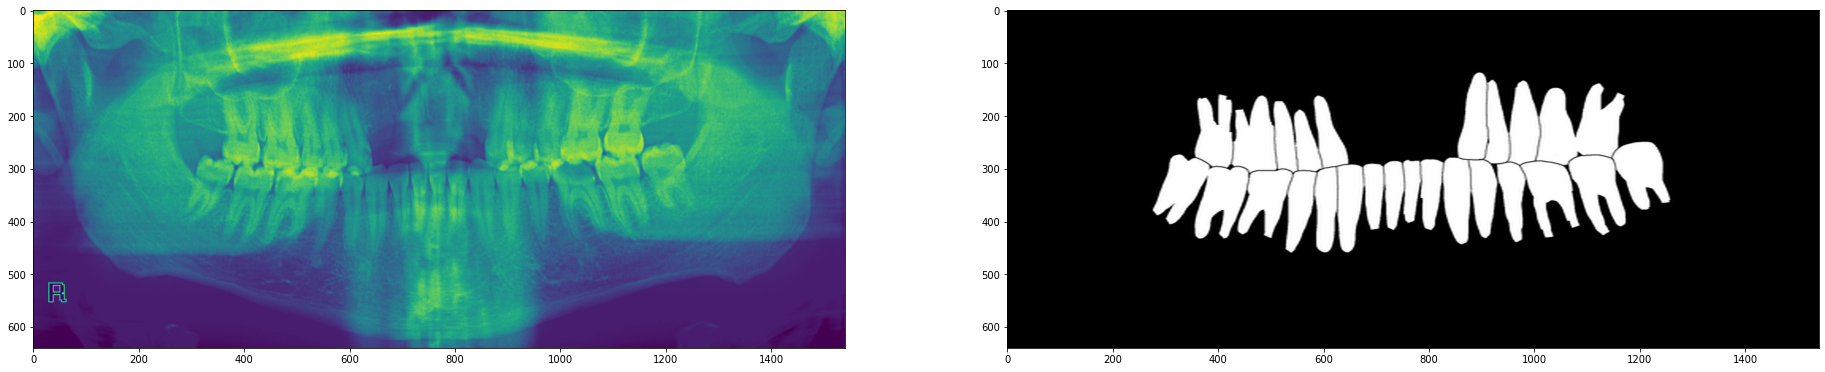

In [ ]:
###Functions for Pre-Process DATA###
def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

def pre_images(resize_shape,path):
    img=Image.open(path)
    img=img.resize((resize_shape),Image.ANTIALIAS)
    img=convert_one_channel(np.asarray(img))
    cv2.imwrite(path,img)
    return img

def resize(resize_shape,path):
    img=Image.open(path)
    # w,h=np.array(img).shape
    # print(w,h)
      # print(img.size)
    img=img.resize((resize_shape),Image.ANTIALIAS)
    return img

# for index in range(10):
#   pre_images((512,512),os.path.join('/content/d/Images', str(index+1)+'.png'))
ress1=Image.open('/content/data/original_img/1.png') #'/content/d/masked_img/1.png'
ress2=Image.open('/content/data/masked_img/1.png')
img1=ress1.resize((1540,640), Image.ANTIALIAS)
img2=ress2.resize((1540,640), Image.ANTIALIAS)

fig = plt.figure(figsize = (32,32))
ax = fig.add_subplot(2, 2, 1) 
plt.imshow(img1)
ax = fig.add_subplot(2, 2, 2) 
plt.imshow(img2)
plt.show()

In [ ]:
# def new(resize_shape,path):
#     img=cv2.imread(path)
#     print(img.shape)
#     # w,h=np.array(img).shape
#     # print(w,h)
# for index in range(10):
#   new((512,512),os.path.join('/content/d/Images', str(index+1)+'.png'))

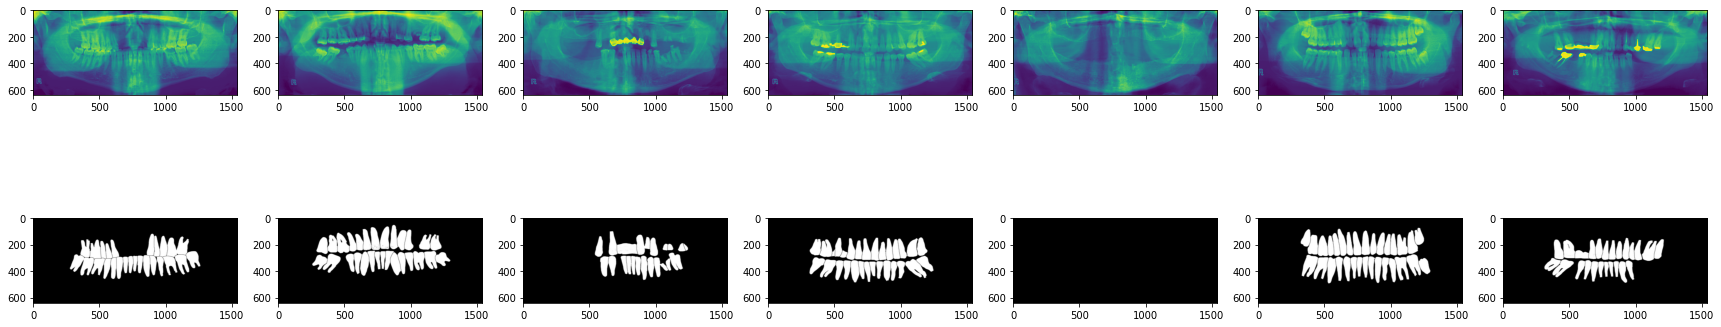

In [ ]:
###display some processed result to double check
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path1 = os.path.join('/content/data/original_img', str(index+1)+'.png')
  file_path2 = os.path.join('/content/data/masked_img', str(index+1)+'.png')
  # print(file_path2)
  ax = fig.add_subplot(2, 7, index+1) 
  plt.imshow(pre_images((1540,640),file_path1))  #show result of converting every img to one color channel
  # plt.imshow(cv2.imread(file_path1))
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(resize((1540,640),file_path2))
  # plt.imshow(cv2.imread(file_path2))
plt.show()
#notice that some images has no teeth, this will make training harder

In [ ]:
###generate file names to keep track of file for later usage
arr1=np.arange(1,117)
# print(arr1.dtype)
arr1=arr1.astype(str)
# print(type(arr1))
df=pd.DataFrame(arr1)
df[1]=df[0]
df[0]=df[0]+'.png'
df.to_csv('/content/data/sample.csv',index=False)

Warning!!! 
<br>The two section below should only run once

In [ ]:
###rename all files in masked_img folder
folder='/content/data/masked_img'
for file_name in os.listdir(folder):
    source = folder+'/'+file_name
    # print(source)

    destination = source.replace('.png','_m.png')
    # print(destination)
    # Renaming the file
    os.rename(source, destination)

In [ ]:
###move renamed files to orginal_image folder
for file_name in os.listdir(folder):
  source = folder+'/'+file_name
  # print(source)
  destination = '/content/data/original_img/'+file_name
  # # print(destination)
  os.rename(source,destination)

In [ ]:
#make sure all pairs a generated
files =  os.listdir('/content/data/original_img')
sorted_files = sorted(files)
print(len(sorted_files))

232


#Loader

In [ ]:
###Load DATA
rest_set_size = 0.3
test_set_size = 0.5
class dset(Dataset):
    def __init__(self, root_dir, train=True,test=True,transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'sample.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.test = test
        
        # split the dataset to train and rest
        # split the rest to validation and test
        self.train_data, self.rest_data = train_test_split(self.pixel_file, test_size = rest_set_size, random_state = 5)
        self.validation_data, self.test_data = train_test_split(self.rest_data, test_size = test_set_size, random_state = 5)

    def __len__(self):
        if self.train:
          length = len(self.train_data)
        elif self.test:
          length = len(self.test_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
        if self.train:
          imx_name = os.path.join(self.root_dir, 'original_img',self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.train_data.iloc[index, 0].replace('.png','_m.png'))
        elif self.test:
          imx_name = os.path.join(self.root_dir, 'original_img',self.test_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.test_data.iloc[index, 0].replace('.png','_m.png'))
        else:
          imx_name = os.path.join(self.root_dir, 'original_img', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.validation_data.iloc[index, 0].replace('.png','_m.png'))
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')

        ##data augmentation
        if self.train:
          #Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # #Random vertical flipping
          # if random.random() > 0.5:
          #     imx = TF.vflip(imx)
          #     imy = TF.vflip(imy)

          # #Random rotation
          # if random.random() > 0.8:
          #   angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
          #   imx = TF.rotate(imx, angle)
          #   imy = TF.rotate(imy, angle)

        if self.transformX:
            imx = self.transformX(imx)
            imy = self.transformY(imy)
      
        sample = {'image': imx, 'annotation': imy}
        return sample

In [ ]:
###initialize data_loaders
tx_X = transforms.Compose([ transforms.Resize((512, 512)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((512, 512)),
                              transforms.ToTensor()
                              ])
train_data = dset('/content/data', train=True, test=False, transformX = tx_X, transformY = tx_Y)
validation_data = dset('/content/data', train=False,test=False,transformX = tx_X, transformY = tx_Y)
test_data = dset('/content/data', train=False, test=True,transformX = tx_X, transformY = tx_Y)

train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True, num_workers=2)
validation_loader = DataLoader(dataset=validation_data, batch_size=2, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset=test_data, batch_size=2, shuffle=True, num_workers=1)

In [ ]:
print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

41
9
9


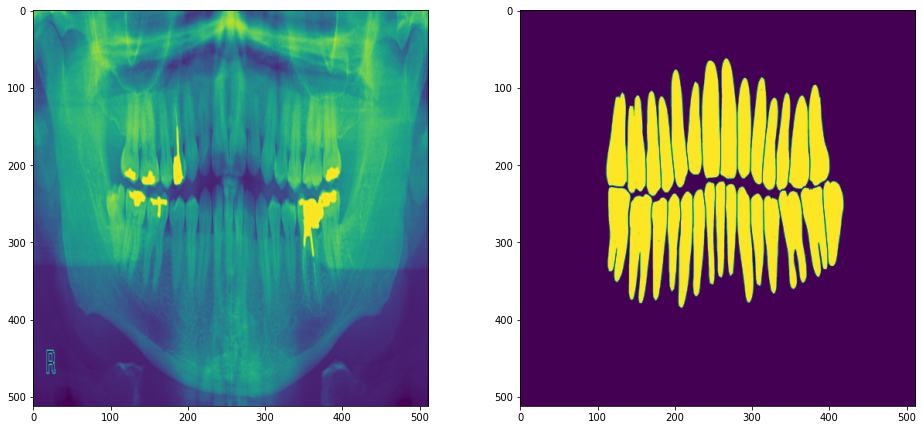

In [ ]:
# print(train_data[0]['image'])
# plt.imshow(train_data[0]['image'].squeeze(0))

#notice that now the image is being resized since it is resized in dataset 
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(2, 2, 1) 
plt.imshow(train_data[0]['image'].squeeze(0))
ax = fig.add_subplot(2, 2, 2) 
plt.imshow(train_data[0]['annotation'].squeeze(0))
plt.show()

#Model

In [ ]:
###try Res-Unet instead of original Unet
class res_conv(nn.Module):
    def __init__(self, input_channels, output_channels, down=True):
        super(res_conv, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.LeakyReLU(inplace = True),
                                   nn.Dropout(0.1),
                                 )
        self.conv2 = nn.Sequential(nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.LeakyReLU(inplace = True),
                                   nn.Dropout(0.1),
                                  )
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)+x1
        return x2

class start_conv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(start_conv, self).__init__()
        self.conv = res_conv(input_channels, output_channels)

    def forward(self, x):
        x = self.conv(x)
        return x


class down_conv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(down_conv, self).__init__()
        self.conv = nn.Sequential(nn.MaxPool2d(2),
                                  res_conv(input_channels, output_channels),)
    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(up_conv, self).__init__()
        self.up = nn.ConvTranspose2d(input_channels//2, input_channels//2, kernel_size=2, stride=2)
        self.conv = res_conv(input_channels, output_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff1 = x2.shape[2]-x1.shape[2]
        diff2 = x2.shape[3]-x1.shape[3]
        x1 = F.pad(x1, pad=(diff1//2, diff1-diff1//2, diff2//2, diff2-diff2//2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class stop_conv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(stop_conv, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=1),
                                 nn.Sigmoid())

    def forward(self, x):
        x = self.conv(x)
        return x

class ResUnet(nn.Module):
    def __init__(self):
        super(ResUnet, self).__init__()
        self.inc = start_conv(1, 64)
        self.down1 = down_conv(64, 128)
        self.down2 = down_conv(128, 256)
        self.down3 = down_conv(256, 512)
        self.down4 = down_conv(512, 512)
        self.up1 = up_conv(1024, 256)
        self.up2 = up_conv(512, 128)
        self.up3 = up_conv(256, 64)
        self.up4 = up_conv(128, 64)
        self.outc = stop_conv(64, 1)

    def forward(self, x):
        xin = self.inc(x)
        xd1 = self.down1(xin)
        xd2 = self.down2(xd1)
        xd3 = self.down3(xd2)
        xd4 = self.down4(xd3)
        xu1 = self.up1(xd4, xd3)
        xu2 = self.up2(xu1, xd2)
        xu3 = self.up3(xu2, xd1)
        xu4 = self.up4(xu3, xin)
        out = self.outc(xu4)
        return out

In [ ]:
model = ResUnet()
if torch.cuda.is_available():
    model = model.to('cuda')

#Loss and Optimizer

In [ ]:
# Using Adam as our optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # weight_decay=

In [ ]:
# Using Loss()
criterion = nn.BCELoss()
train_hist, val_hist = None, None

In [ ]:
# Dice Loss function
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)

    return dice

def dice_loss(y_predict, y_train): ## to add in bce looss
  dice_loss = 1 -(dice_index(y_predict, y_train))
  return dice_loss

#Train and Validation

In [ ]:
from tqdm.notebook import tqdm
def train(model, criterion, epochs = 5, verbose=False, train_hist=None, val_hist=None):
  if not train_hist:
    train_hist = []
  if not val_hist:
    val_hist = []
    
  torch.cuda.empty_cache()
    
  tqdm.write("====== Training Started ======")
  epochs_completed = 0
  try:
    for e in tqdm(range(epochs), position=0, desc="Epochs", leave=False, colour='green'):
      train_running_loss = 0.0
      validation_running_loss = 0.0
      ct = 0.0
      
      model.train()
      
      # print("Losses are reset to:", train_running_loss, validation_running_loss, ct)
      for ith_batch, sample in tqdm(enumerate(train_loader), position=1, desc="Batches", leave=False, total=len(train_loader), colour='blue'):
        X, Y = sample['image'], sample['annotation']
      #   plt.imshow(pred.detach().numpy()[0].transpose(1, 2, 0))

        if torch.cuda.is_available():
          X = X.to('cuda')
          Y = Y.to('cuda')

        y_pred = model(X)
      # out = (y_pred + 0.5).int().float()
        
        # loss = criterion(y_pred, Y) #* 0.70 + 0.30 * dice_loss(y_pred, y_train)
        loss=0.3*dice_loss(y_pred, Y)+0.7*criterion(y_pred, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and ith_batch % 10 == 0 and ith_batch != 0:
          # print("This item's loss:", f'{loss.item()}')
          # print("This pred started with", y_pred[0][0][0][0:10])
          tqdm.write('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Curr Epoch Loss: ', f'{train_running_loss / ct:0.3f}')
          
        train_running_loss += loss.item()
        train_hist.append(loss.item())
        ct += 1.0
        
      with torch.no_grad():
        
        model.eval()
        
        for ith_batch, sample in enumerate(validation_loader):
            X_val, y_val = sample['image'], sample['annotation']
            
            if torch.cuda.is_available():
              X_val = X_val.to('cuda')
              y_val = y_val.to('cuda')
            
            y_out = model(X_val)
            
            # print("Pred is", y_out[y_out.shape[0]//2,y_out.shape[1]//2-1:y_out.shape[1]//2+1])
            val_loss = criterion(y_out, y_val)

            validation_running_loss += val_loss.item()
            val_hist.append(val_loss.item())

      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(validation_loader)
        
      if verbose:
        tqdm.write("================================================================================")
        tqdm.write("Epoch {} completed".format(e + 1))
        tqdm.write("Average train loss is {:0.3f}: ".format(train_epoch_loss))
        tqdm.write("Average validation loss is {:0.3f}".format(validation_epoch_loss))
        tqdm.write("================================================================================")
      else:
        tqdm.write(f"Epoch {e + 1}. Train Loss: {train_epoch_loss:0.4f} Val Loss: {validation_epoch_loss:0.4f}")
      epochs_completed = e + 1
      torch.cuda.empty_cache()
  except Exception as e:
    print("Exception:", e)
    print("Halting training and returning historical loss data")
  return train_hist, val_hist, epochs_completed

In [ ]:
total_epochs=0

In [ ]:
num_epochs = 100
# Including train_hist, val_hist in our parameters allows us to retain our previously saved loss data 
# and visualize the full training graph
train_hist, val_hist, completed_epochs = train(model, criterion, epochs=num_epochs, verbose=False, train_hist=train_hist, val_hist=val_hist)
total_epochs+=completed_epochs

====== Training Started ======


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1. Train Loss: 0.4372 Val Loss: 0.5144


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 2. Train Loss: 0.2400 Val Loss: 0.2514


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 3. Train Loss: 0.2038 Val Loss: 0.2436


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 4. Train Loss: 0.1800 Val Loss: 0.2408


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 5. Train Loss: 0.1658 Val Loss: 0.1860


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 6. Train Loss: 0.1629 Val Loss: 0.1543


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 7. Train Loss: 0.1484 Val Loss: 0.1839


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 8. Train Loss: 0.1398 Val Loss: 0.1693


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 9. Train Loss: 0.1305 Val Loss: 0.1528


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 10. Train Loss: 0.1290 Val Loss: 0.1473


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 11. Train Loss: 0.1247 Val Loss: 0.1489


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 12. Train Loss: 0.1196 Val Loss: 0.1396


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 13. Train Loss: 0.1205 Val Loss: 0.1404


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 14. Train Loss: 0.1156 Val Loss: 0.1441


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 15. Train Loss: 0.1108 Val Loss: 0.1289


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 16. Train Loss: 0.1091 Val Loss: 0.1365


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 17. Train Loss: 0.1052 Val Loss: 0.1580


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 18. Train Loss: 0.1004 Val Loss: 0.1293


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 19. Train Loss: 0.1008 Val Loss: 0.1553


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 20. Train Loss: 0.0952 Val Loss: 0.1112


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 21. Train Loss: 0.0959 Val Loss: 0.1224


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 22. Train Loss: 0.0931 Val Loss: 0.1339


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 23. Train Loss: 0.0900 Val Loss: 0.1166


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 24. Train Loss: 0.0897 Val Loss: 0.1270


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 25. Train Loss: 0.0881 Val Loss: 0.1431


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 26. Train Loss: 0.0884 Val Loss: 0.1388


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 27. Train Loss: 0.0857 Val Loss: 0.1190


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 28. Train Loss: 0.0823 Val Loss: 0.1486


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 29. Train Loss: 0.0816 Val Loss: 0.1223


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 30. Train Loss: 0.0793 Val Loss: 0.1238


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 31. Train Loss: 0.0795 Val Loss: 0.1376


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 32. Train Loss: 0.0804 Val Loss: 0.1157


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 33. Train Loss: 0.0776 Val Loss: 0.1345


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 34. Train Loss: 0.0804 Val Loss: 0.1471


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 35. Train Loss: 0.0868 Val Loss: 0.1586


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 36. Train Loss: 0.0764 Val Loss: 0.1445


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 37. Train Loss: 0.0749 Val Loss: 0.1245


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 38. Train Loss: 0.0749 Val Loss: 0.2013


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 39. Train Loss: 0.0713 Val Loss: 0.1241


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 40. Train Loss: 0.0739 Val Loss: 0.1378


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 41. Train Loss: 0.0739 Val Loss: 0.1299


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 42. Train Loss: 0.0711 Val Loss: 0.1341


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 43. Train Loss: 0.0675 Val Loss: 0.1184


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 44. Train Loss: 0.0677 Val Loss: 0.1460


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 45. Train Loss: 0.0669 Val Loss: 0.1400


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 46. Train Loss: 0.0649 Val Loss: 0.1396


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 47. Train Loss: 0.0636 Val Loss: 0.1299


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 48. Train Loss: 0.0631 Val Loss: 0.1498


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 49. Train Loss: 0.0622 Val Loss: 0.1549


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 50. Train Loss: 0.0621 Val Loss: 0.1457


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 51. Train Loss: 0.0633 Val Loss: 0.1213


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 52. Train Loss: 0.0602 Val Loss: 0.1484


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 53. Train Loss: 0.0644 Val Loss: 0.1322


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 54. Train Loss: 0.0640 Val Loss: 0.1523


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 55. Train Loss: 0.0601 Val Loss: 0.1547


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 56. Train Loss: 0.0578 Val Loss: 0.1516


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 57. Train Loss: 0.0571 Val Loss: 0.1469


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 58. Train Loss: 0.0834 Val Loss: 0.1306


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 59. Train Loss: 0.0854 Val Loss: 0.1866


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 60. Train Loss: 0.0674 Val Loss: 0.1358


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 61. Train Loss: 0.0628 Val Loss: 0.1361


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 62. Train Loss: 0.0609 Val Loss: 0.1297


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 63. Train Loss: 0.0565 Val Loss: 0.1521


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 64. Train Loss: 0.0553 Val Loss: 0.1683


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 65. Train Loss: 0.0546 Val Loss: 0.1527


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 66. Train Loss: 0.0535 Val Loss: 0.1571


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 67. Train Loss: 0.0525 Val Loss: 0.1952


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 68. Train Loss: 0.0518 Val Loss: 0.1612


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 69. Train Loss: 0.0520 Val Loss: 0.1538


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 70. Train Loss: 0.0503 Val Loss: 0.1533


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 71. Train Loss: 0.0501 Val Loss: 0.1452


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 72. Train Loss: 0.0504 Val Loss: 0.1662


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 73. Train Loss: 0.0499 Val Loss: 0.1627


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 74. Train Loss: 0.0496 Val Loss: 0.1565


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 75. Train Loss: 0.0490 Val Loss: 0.1590


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 76. Train Loss: 0.0481 Val Loss: 0.1529


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 77. Train Loss: 0.0478 Val Loss: 0.1662


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 78. Train Loss: 0.0477 Val Loss: 0.1475


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 79. Train Loss: 0.0487 Val Loss: 0.1497


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 80. Train Loss: 0.0515 Val Loss: 0.1650


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 81. Train Loss: 0.0481 Val Loss: 0.1603


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 82. Train Loss: 0.0468 Val Loss: 0.1695


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 83. Train Loss: 0.0467 Val Loss: 0.1664


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 84. Train Loss: 0.0463 Val Loss: 0.1744


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 85. Train Loss: 0.0456 Val Loss: 0.1583


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 86. Train Loss: 0.0450 Val Loss: 0.1634


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 87. Train Loss: 0.0447 Val Loss: 0.1682


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 88. Train Loss: 0.0437 Val Loss: 0.1556


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 89. Train Loss: 0.0445 Val Loss: 0.1593


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 90. Train Loss: 0.0450 Val Loss: 0.1696


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 91. Train Loss: 0.0438 Val Loss: 0.1632


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 92. Train Loss: 0.0435 Val Loss: 0.1580


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 93. Train Loss: 0.0686 Val Loss: 0.2017


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 94. Train Loss: 0.0712 Val Loss: 0.1343


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 95. Train Loss: 0.0561 Val Loss: 0.2036


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 96. Train Loss: 0.0485 Val Loss: 0.1713


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 97. Train Loss: 0.0472 Val Loss: 0.1773


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 98. Train Loss: 0.0455 Val Loss: 0.2034


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 99. Train Loss: 0.0443 Val Loss: 0.1904


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 100. Train Loss: 0.0433 Val Loss: 0.1791


In [ ]:
def im_converterX(tensor):
    image = tensor.cpu().clone().detach().numpy() 
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
    # print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image # this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

def im_converterX1(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image=image.squeeze(0) 
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    # image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image # this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

def im_converterY(tensor):
    image = tensor.cpu().clone().detach().numpy() 
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
    # print(image.shape)
    image = image * np.array((1, 1, 1)) # unnormalizing the image  not needed# this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

def im_converterY1(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image=image.squeeze(0) 
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((1, 1, 1)) # unnormalizing the image  not needed# this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

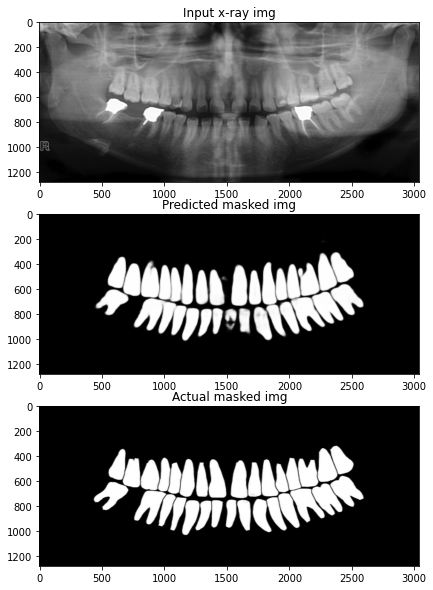

In [ ]:
###Visualiza some data to see how model perform qualitatively
pig = plt.figure(figsize = (16, 10))
dim=3040,1280
for i, sample in enumerate(validation_loader):
    Xs, Ys = sample["image"], sample["annotation"]
    
    a = pig.add_subplot(3, 1, 1)
    imgx=im_converterX(Xs[0])
    imgx=cv2.resize(imgx, dim, interpolation = cv2.INTER_AREA)
    plt.title('Input x-ray img')
    plt.imshow(imgx)

    Xs = Xs.to("cuda")
    a = pig.add_subplot(3, 1, 2)
    output_img=im_converterY(model(Xs)[0])
    output_img=cv2.resize(output_img, dim, interpolation = cv2.INTER_AREA)
    plt.title('Predicted masked img')
    plt.imshow(output_img)

    a = pig.add_subplot(3, 1, 3)
    imgy=im_converterY(Ys[0])
    imgy=cv2.resize(imgy, dim, interpolation = cv2.INTER_AREA)
    plt.title('Actual masked img')
    plt.imshow(imgy)

    break
plt.show()

In [ ]:
train_means, val_means = [], []
def plot_loss(title="Without Data Augmentation", ylabel="Loss", xlabel="Epochs"):
    for i in range(total_epochs):
        train_means.append(np.mean(train_hist[len(train_loader)*i:len(train_loader)*(i+1)]))
        val_means.append(np.mean(val_hist[len(validation_loader)*i:len(validation_loader)*(i+1)]))
    plt.plot(train_means, label = 'Train Loss')
    plt.plot(val_means, label = 'Validation Loss')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()

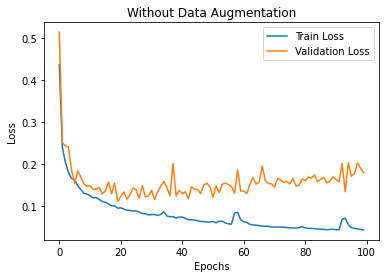

In [ ]:
plot_loss()

In [ ]:
print(min(train_means))

0.043293762861228574


In [ ]:
torch.save(model.state_dict(),'/content/best_unet_051722_v1.pth')

#Test

In [ ]:
###Load DATA

test_set_size = 0.5
class dset(Dataset):
    def __init__(self, root_dir, train=True,test=True,transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'sample.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.test = test
        
        # split the dataset to train and rest
        # split the rest to validation and test
        self.train_data, self.test_data = train_test_split(self.pixel_file, test_size = test_set_size, random_state = 5)
        # self.validation_data, self.test_data = train_test_split(self.rest_data, test_size = test_set_size, random_state = 5)

    def __len__(self):
        if self.train:
          length = len(self.train_data)
        elif self.test:
          length = len(self.test_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
        if self.train:
          imx_name = os.path.join(self.root_dir, 'original_img',self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.train_data.iloc[index, 0].replace('.png','_m.png'))
        elif self.test:
          imx_name = os.path.join(self.root_dir, 'original_img',self.test_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.test_data.iloc[index, 0].replace('.png','_m.png'))
        else:
          imx_name = os.path.join(self.root_dir, 'original_img', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.validation_data.iloc[index, 0].replace('.png','_m.png'))
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')

        if self.transformX:
            imx = self.transformX(imx)
            imy = self.transformY(imy)
      
        sample = {'image': imx, 'annotation': imy}
        return sample

In [ ]:
tx_X = transforms.Compose([ transforms.Resize((512, 512)),
                              transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((512, 512)),
                              transforms.ToTensor()
                              ])
train_data = dset('/content/data', train=True, test=False, transformX = tx_X, transformY = tx_Y)
# validation_data = dset('/content/data', train=False,test=False,transformX = tx_X, transformY = tx_Y)
test_data = dset('/content/data', train=False, test=True,transformX = tx_X, transformY = tx_Y)

train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True, num_workers=2)
# validation_loader = DataLoader(dataset=validation_data, batch_size=2, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset=test_data, batch_size=2, shuffle=True, num_workers=1)

In [ ]:
#test
def avg_dice_index(dataloader): 
    dice = 0.0
    model.eval()
    with torch.no_grad():
        for ith_batch, sample_batched in enumerate(dataloader):
  
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            
            y_predict = (model(X_train) + 0.5).int().float()
            
            dice += dice_index(y_predict, y_train)
            
    print(len(dataloader))
    avg_dice = dice / len(dataloader)
    
    return avg_dice.item()

In [ ]:
test_score=avg_dice_index(test_loader)

29


In [ ]:
print('Avergae Dice Score is:',test_score)
print('Avergae Dice Loss is:',1-test_score)

Avergae Dice Score is: 0.9117302298545837
Avergae Dice Loss is: 0.08826977014541626


#Post-Process

0


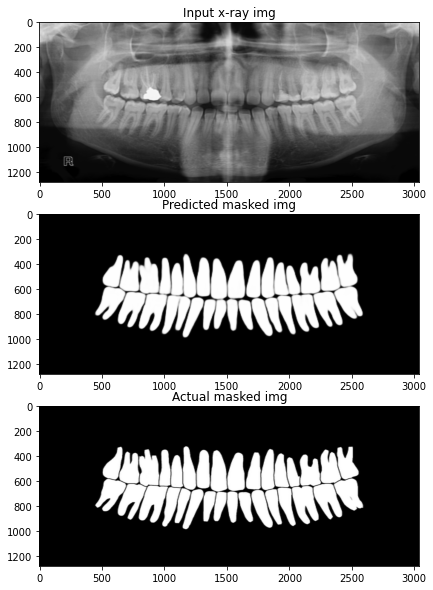

In [ ]:
pig = plt.figure(figsize = (16, 10))
dim=3040,1280

for i, sample in enumerate(test_loader):
    print(i)
    Xs, Ys = sample["image"], sample["annotation"]
    
    a = pig.add_subplot(3, 1, 1)
    imgx=im_converterX(Xs[0])
    imgx=cv2.resize(imgx, dim, interpolation = cv2.INTER_AREA)
    plt.title('Input x-ray img')
    plt.imshow(imgx)

    Xs = Xs.to("cuda")
    a = pig.add_subplot(3, 1, 2)
    output_img=im_converterY(model(Xs)[0])
    output_img=cv2.resize(output_img, dim, interpolation = cv2.INTER_AREA)
    plt.title('Predicted masked img')
    plt.imshow(output_img)

    a = pig.add_subplot(3, 1, 3)
    imgy=im_converterY(Ys[0])
    imgy=cv2.resize(imgy, dim, interpolation = cv2.INTER_AREA)
    plt.title('Actual masked img')
    plt.imshow(imgy)

    break
plt.show()

In [ ]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from imutils import perspective
from imutils import contours
from scipy.spatial import distance as dist

from skimage.segmentation import watershed
from skimage.measure import label
from skimage.color import label2rgb
from skimage import measure

def ConnectedComp(img):
  # Load in image, convert to gray scale, and Otsu's threshold
  kernel =(np.ones((3,3), dtype=np.float32))
  # print(img.dtype)
  image=cv2.resize(img.astype(np.float32),(3040,1280))
  image=cv2.morphologyEx(image, cv2.MORPH_OPEN,kernel)
  
  # sharpen=np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
  # image=cv2.filter2D(image,-1,sharpen)
  
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # print(gray)
  grayy = (gray*255*10).astype(np.uint8)
  print(grayy)

  thresh = cv2.threshold(grayy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  # print(thresh)
  erosion = cv2.erode(thresh,kernel,iterations=3) #,iterations=2
  #gradient, aka the contours
  gradient = cv2.morphologyEx(erosion, cv2.MORPH_GRADIENT, kernel)

  ret,markers=cv2.connectedComponents(erosion,connectivity=8)
  new = watershed(erosion,markers,mask=thresh)
  RGB = label2rgb(new, bg_label=0)


  return erosion,gradient,RGB
  # return erosion
erosion,gradient,RGB=ConnectedComp(output_img)

[[5 5 5 ... 4 4 4]
 [5 5 5 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [1 1 1 ... 3 3 3]
 [2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]]


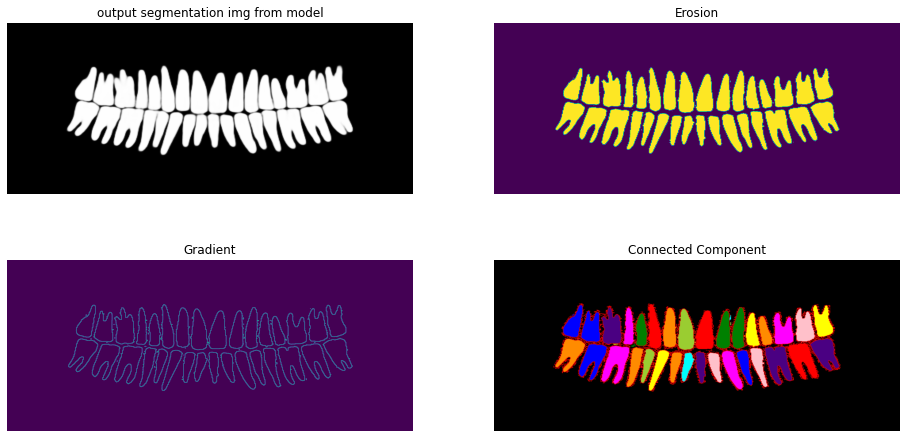

In [ ]:
# erosion,gradient,RGB=ConnectedComp(output_img)
# gray=ConnectedComp(output_img)
# print(gray*255*10)

fig = plt.figure(figsize = (16,8))

ax = fig.add_subplot(2, 2, 1) 
plt.title('output segmentation img from model')
plt.axis('off')
plt.imshow(output_img)

ax = fig.add_subplot(2, 2, 2) 
plt.title('Erosion')
plt.axis('off')
plt.imshow(erosion)

ax = fig.add_subplot(2,2,3) 
plt.title('Gradient')
plt.axis('off')
plt.imshow(gradient)

ax = fig.add_subplot(2,2,4) 
plt.title('Connected Component')
plt.axis('off')
plt.imshow(RGB)

plt.show()